In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator -> NON USARE PIU'

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
if not os.path.isfile("data/Food-5k.zip"):
    ! curl -o "data/Food-5k.zip" "https://archive.org/download/food-5-k/Food-5K.zip"

#### Nota:
Siccome il link non funzionava, ho scaricato il dataset da kaggle. Questo è in forma "train - evaluate - validate", ognuno contenente due folder: una per la classe food, una per la classe non_food.

Il dataset al link, invece, aveva i dati strutturati in maniera diversa. Per questo motivo sarebbe stato necessario compiere una serie di modifiche, splittando manualmente i file.

In [3]:
train_path = "data/Food-5k/training"
val_path = "data/Food-5k/evaluation"

In [4]:
IMAGE_SIZE = [200, 200]

In [5]:
# Cerchiamo di capire quanti campioni abbiamo usando la funzione glob cercando tutti i file jpg
image_files = glob(train_path + "/*/*.jpg")
val_image_files = glob(val_path + "/*/*.jpg")

In [6]:
# Qui invece il numero di classi
folders = glob(train_path+"/*")
classes = len(folders)
folders

['data/Food-5k/training\\food', 'data/Food-5k/training\\non_food']

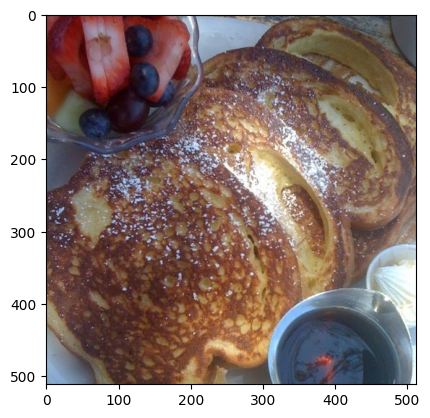

In [7]:
plt.imshow(image.load_img(np.random.choice(image_files)));

In [8]:
vgg16 = PretrainedModel(
    input_shape=IMAGE_SIZE+[3],
    weights="imagenet", # Permette di scaricare i pesi di VGG16 basato sul dataset imagenet
    include_top=False # Choppiamo via la testa della rete, tenendo solo le convoluzioni
)

In [9]:
vgg16.trainable = False

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [11]:
# Il nostro modello adesso dovrà gestire tutto quanto!
i = Input(shape=IMAGE_SIZE+[3])
o = preprocess_input(i)
o = data_augmentation(o)
o = vgg16(o)
o = Flatten()(o)
o = Dense(classes, activation="softmax")(o) # Siccome stiamo usando il data generator, avremo la classificazione 1hotencoded, quindi softmax

model = Model(inputs=i, outputs=o)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 200, 200, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 200, 200)          │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 200, 200)          │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 200, 200)          │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stack (Stack)                 │ (None, 200, 200, 3)       │               0 │ get_item[0][0],            │
│                               │                           │                 │ get_item_1[0][0],          │
│                               │                           │                 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 200, 200, 3)       │               0 │ stack[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 200, 200, 3)       │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 6, 6, 512)         │      14,714,688 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 18432)             │               0 │ vgg16[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 2)                 │          36,866 │ flatten[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,751,554 (56.27 MB)

 Trainable params: 36,866 (144.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

### Cambiamo dai generatori ai datasets

In [13]:
from tensorflow.keras.utils import image_dataset_from_directory

In [14]:
batch_size = 128
train_ds = image_dataset_from_directory(
    train_path,
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    label_mode="categorical"
)

val_ds = image_dataset_from_directory(
    val_path,
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    label_mode="categorical"
)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [15]:
# optimization
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
r = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=1
)

24/24 ━━━━━━━━━━━━━━━━━━━━ 220s 9s/step - accuracy: 0.9815 - loss: 0.2993 - val_accuracy: 0.9780 - val_loss: 0.6960


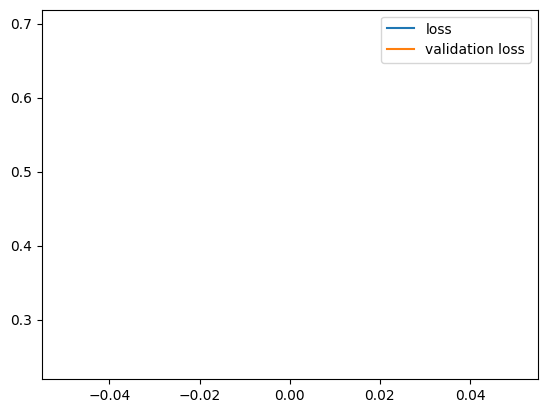

In [19]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="validation loss")
plt.legend()

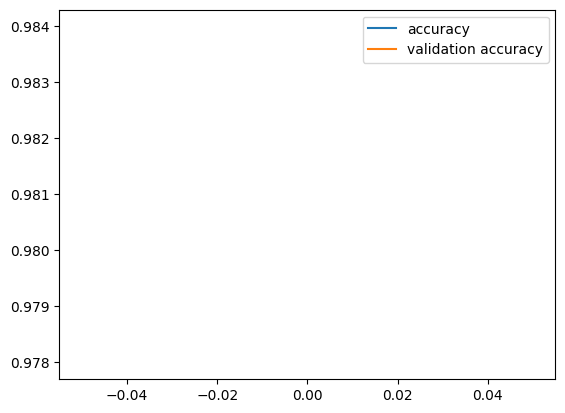

In [20]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="validation accuracy")
plt.legend()